# Implementing Low-Pass and High-Pass Filters through the DCT

Author: Pramith Devulapalli

An interesting feature about the spectral representation of most images is that the dominant coefficients lie in the lower frequencies. Additionally, the higher frequencies of an image represent drastic contrasts in the image and this usually correlates to edges in the image. The different frequencies of an image represent different features about the image.

Low-pass filters are filters that pass signals with frequencies lower than a specified cutoff frequency. For frequencies higher than the cutoff frequency, these are attenuated or in an ideal scenario, completely removed. Low-pass filters in images allow one to remove high-frequency noise from the image and allow blurring of images.

High-pass filters are filters that pass signals with higher frequencies than a specified cutoff frequency. For frequencies lower than the cutoff frequency, these frequencies are attenuated or completely removed. Many edge detectors used in imaging applications are primarily based off of high-pass filters. 

In this notebook, I implemented different types of low-pass and high-pass filters through the DCT and Gaussian based methods.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import scipy.fftpack
import scipy.misc as misc
import cv2
import math
import os

In [125]:
img = cv2.imread('MJ_Bulls.jpg', 0)  # Greyscale image

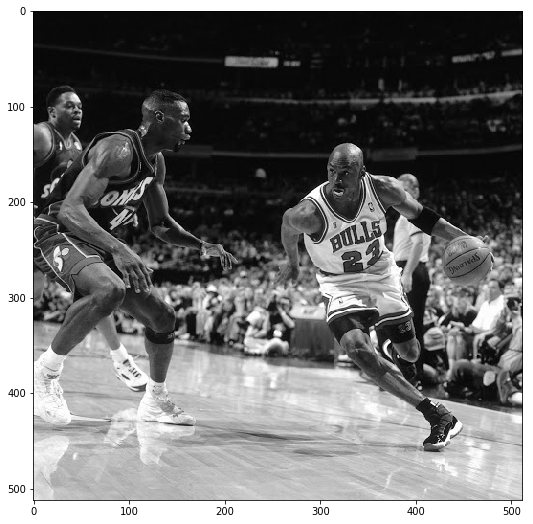

In [130]:
plt.figure(figsize=(9,9))
plt.imshow(img, cmap ='gray')

## DCT Based Low-Pass and High-Pass Filter

In the previous exercise, I implemented the DCT only in a 1-D sense. In this notebook, I have expanded the DCT for two dimensions. Additionally, I have programmed in a check to see if my 2-D DCT implementation matches that of scipy.fftpack.dct.

In [154]:
def bit_reversal(a):
    array = np.zeros(a.shape)
    array = array.astype('complex')
    log = int(math.log(array.size, 2))
    for n in range(a.size):
        b = '{:0{width}b}'.format(n, width=log)
        array[n] = a[int(b[::-1], 2)]
    return array

def ButterflyComputationFFT_Exp(input_array):
    N = input_array.size
    twiddle = complex(np.cos(2.0*np.pi/N), -1.0*np.sin(2.0*np.pi/N))
    for i in range(int(N/2)):
        factor = twiddle**i
        a = input_array[int(i)]
        input_array[int(i)] = a + factor*input_array[int(i+N/2)]
        input_array[int(i+N/2)] = a + -1.0*factor*input_array[int(i+N/2)]
    return input_array

def FFT_Exp(ar):
    complex_array = np.zeros(ar.shape)
    complex_array = complex_array.astype('complex')
    complex_array = bit_reversal(ar)
    iterations = math.log(ar.size, 2)-1
    while (iterations > -1):
        step = complex_array.size/(2**iterations)
        j = 0
        while (j < complex_array.size):
            complex_array[int(j):int(j+step)] = ButterflyComputationFFT_Exp(complex_array[int(j):int(j+step)])
            j = j + step
        iterations = iterations - 1
    return complex_array

def ConvertToDCT_Exp(fft_input):
    fft = np.zeros((2*fft_input.size))
    fft[:fft_input.size] = fft_input
    fft[fft_input.size:] = 0
    dct = np.zeros(fft.shape)
    dct = dct.astype('complex')
    dct = FFT_Exp(fft)
    for i in range(len(dct)):
        dct[i] = 2*dct[i]*np.exp(-1j*np.pi*i/(2*fft_input.size))
    return dct.real[0:fft_input.size]

def DCT_Normalized(dct):
    for i in range(len(dct)):
        if i == 0:
            dct[i] = dct[i]*np.sqrt(1/(4*dct.size))
        else:
            dct[i] = dct[i]*np.sqrt(1/(2*dct.size))
    return dct

def DCT2(arr, N):
    output = np.zeros((N, N))
    for i in range(N):
        output[i,:] = DCT_Normalized(ConvertToDCT_Exp(arr[i,:]))
    
    for j in range(N):
        output[:,j] = DCT_Normalized(ConvertToDCT_Exp(output[:,j]))
    return output

def IDCT_2d(dct):
    return scipy.fftpack.idct(scipy.fftpack.idct(dct.T, norm='ortho').T, norm='ortho')

In [155]:
np.random.seed(1)
a = np.random.random((16,16))
a = a*255

In [156]:
# Check to see if the 2-D dimensional DCT matches that of scipy.fftpack
test = scipy.fftpack.dct(scipy.fftpack.dct(a-128, norm = 'ortho').T, norm = 'ortho').T
test2 = DCT2(a-128, 16)
np.allclose(test, test2)

True

### Low-Pass Filter

A low-pass filter using the DCT can easily be implemented. First, run the image through the DCT. Arbitrarily set a cutoff frequency where any frequency greater than the cutoff frequency is set to 0. Perform the inverse DCT and display the image.

In [142]:
img = img.astype('float')
dct2_low = DCT2(img-128, 512)

In [164]:
# Select first 20 frequencies along both rows and columns
dct2_low[20:, 20:] = 0
# Convert back to the image
image_low_pass = IDCT_2d(dct2_low)
# Add +128 back to the image to restore pixel values
image_low_pass = image_low_pass + 128

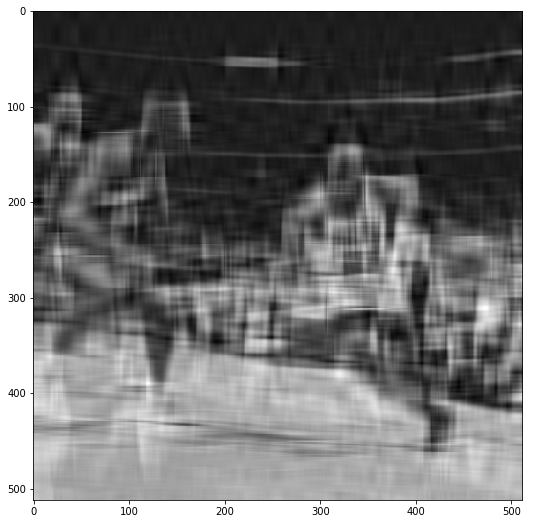

In [165]:
plt.figure(figsize=(9,9))
plt.imshow(image_low_pass, cmap = 'gray')

In [166]:
dct2_low2 = DCT2(img-128, 512)

In [167]:
# Select first 60 frequencies along both rows and columns
dct2_low2[60:, 60:] = 0
# Convert back to the image
image_low_pass2 = IDCT_2d(dct2_low2)
# Add +128 back to the image to restore pixel values
image_low_pass2 = image_low_pass2 + 128

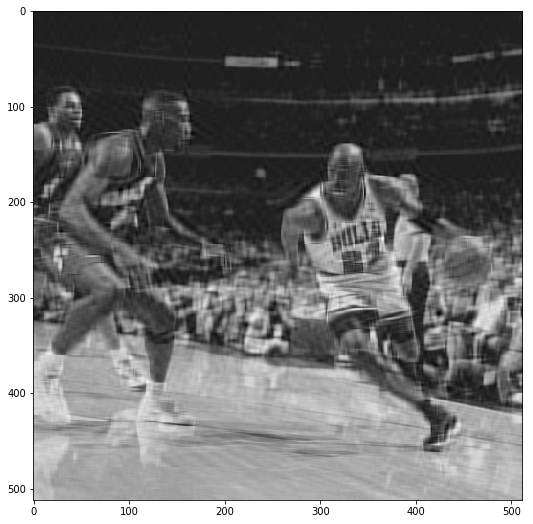

In [168]:
plt.figure(figsize=(9,9))
plt.imshow(image_low_pass2, cmap = 'gray')

In [169]:
dct2_low3 = DCT2(img-128, 512)

In [185]:
# Select first 100 frequencies along both rows and columns
dct2_low3[100:, 100:] = 0
# Convert back to the image
image_low_pass3 = IDCT_2d(dct2_low3)
# Add +128 back to the image to restore pixel values
image_low_pass3 = image_low_pass3 + 128

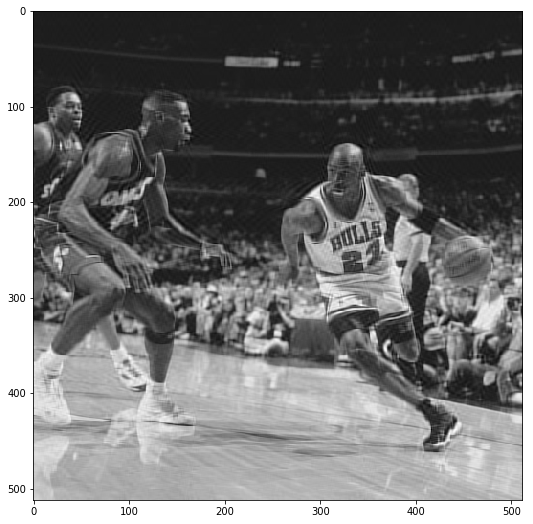

In [188]:
plt.figure(figsize=(9,9))
plt.imshow(image_low_pass3, cmap = 'gray')

### High-Pass Filter

The high-pass filter follows in similar fashion by setting a cutoff frequency. Any frequency lower than the cutoff frequency is set to 0. 

In [189]:
dct2_high = DCT2(img-128, 512)

In [190]:
# Remove first 20 frequencies along both rows and columns and set them to 0
dct2_high[:20, :20] = 0
# Convert back to the image
image_high_pass = IDCT_2d(dct2_high)
# Add +128 back to the image to restore pixel values
image_high_pass = image_high_pass + 128

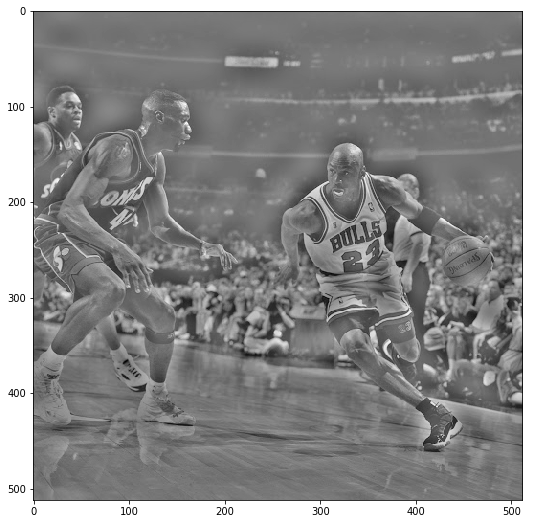

In [191]:
plt.figure(figsize=(9,9))
plt.imshow(image_high_pass, cmap = 'gray')

In [193]:
dct2_high2 = DCT2(img-128, 512)

In [194]:
# Remove first 60 frequencies along both rows and columns and set them to 0
dct2_high2[:60, :60] = 0
# Convert back to the image
image_high_pass2 = IDCT_2d(dct2_high2)
# Add +128 back to the image to restore pixel values
image_high_pass2 = image_high_pass2 + 128

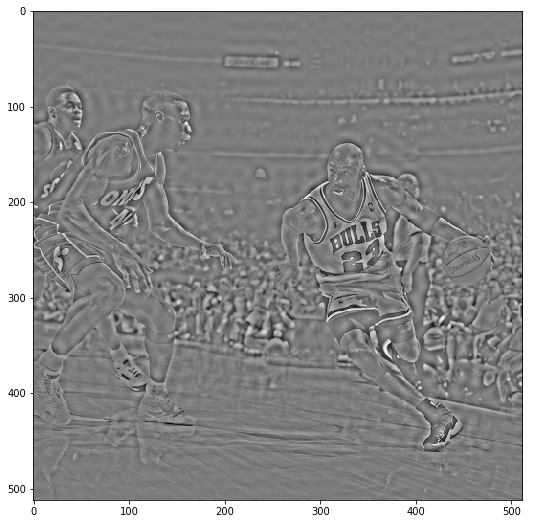

In [195]:
plt.figure(figsize=(9,9))
plt.imshow(image_high_pass2, cmap = 'gray')

In [196]:
dct2_high3 = DCT2(img-128, 512)

In [197]:
# Remove first 100 frequencies along both rows and columns and set them to 0
dct2_high3[:100, :100] = 0
# Convert back to the image
image_high_pass3 = IDCT_2d(dct2_high3)
# Add +128 back to the image to restore pixel values
image_high_pass3 = image_high_pass3 + 128

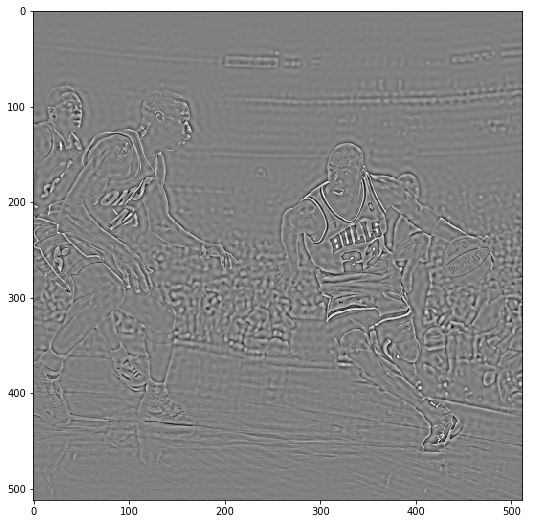

In [199]:
plt.figure(figsize=(9,9))
plt.imshow(image_high_pass3, cmap = 'gray')

### Gaussian Low-Pass and High-Pass Filters

Another form of low-pass and high-pass filters are implemented through a 2-d gaussian function. A prominent feature that occurs with the "ideal" low-pass and high-pass filter is the circular ring effect. The images when processed through these filters seem to have a ring like effect that mirrors a water droplet hitting a liquid surface. In order to remove this feature, a smoothing filter is used through the gaussian function.

Using a gaussian filter removes this phenomenon and smoothes the image. A gaussian low-pass filter uses a kernel (dimensions specified by user) created from sampling a 2-d gaussian function. This kernel is then convolved over the image to blur the image.

A high-pass gaussian filter is created by subtracting the original image from an image that is passed through a gaussian low-pass filter. Low-pass and high-pass filters are complements so subtracting the original image from the low-pass image will yield a high-pass image.

In [200]:
# The zero padding function pads 0s around the original image so that the box filter can operate the kernel on edge pixels 
def zero_padding(image, kernel):
    array = np.zeros((image.shape[0]+kernel.shape[0]-1, image.shape[1]+kernel.shape[1]-1), np.float64)
    row1 = int((kernel.shape[0]-1)/2)
    row2 = int(row1 + image.shape[0])
    col1 = int((kernel.shape[1]-1)/2)
    col2 = int(col1 + image.shape[1])
    array[row1:row2,col1:col2] = image
    return array

# Greyscale blur filter that takes in a kernel and applies it to the image
def greyscale_blur_filter(image, kernel):
    x1 = int((kernel.shape[0] - 1)/2)
    x2 = int(x1 + image.shape[0])
    y1 = int((kernel.shape[1] - 1)/2)
    y2 = int(y1 + image.shape[1])
    array = zero_padding(image, kernel)
    arrayOut = np.zeros(image.shape, dtype=np.uint8)
    for x in range(x1, x2):
        for y in range(y1, y2):
            xOrig = x-(kernel.shape[0]-1)/2
            yOrig = y-(kernel.shape[1]-1)/2
            multiply = array[int(xOrig):int(xOrig+kernel.shape[0]),int(yOrig):int(yOrig+kernel.shape[1])]
            replace = np.multiply(multiply, kernel)
            arrayOut[x-x1,y-y1] = int(np.sum(replace))
        
    return arrayOut

# Two Dimensional Gaussian function
def TwoD_gaussian_function(x,y,sigma,mean):
    return (1./(2.*np.pi*sigma**2))*np.exp(-1*(((x-mean)**2 + (y-mean)**2)/(2.*sigma**2)))

# Gaussian kernel 
def gaussian_kernel(n):
    sigma = math.ceil(n/2)/3
    mean = math.floor(n/2)
    gauss = np.ones((n,n),np.float64)
    for i in range(0, n):
        for j in range(0, n):
            gauss[i,j] = TwoD_gaussian_function(j,i,sigma,mean)
    return gauss

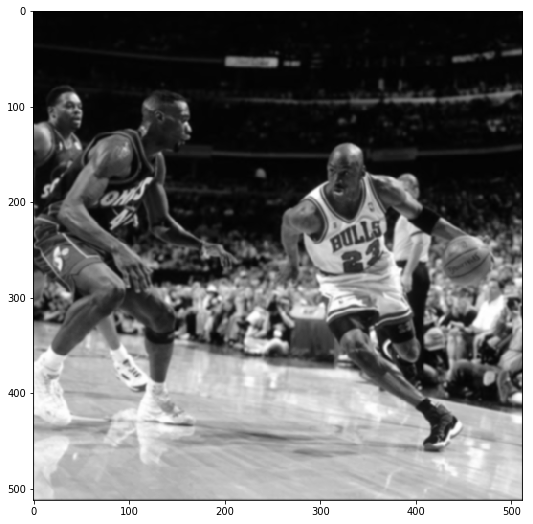

In [203]:
image = greyscale_blur_filter(img, gaussian_kernel(5))
plt.figure(figsize=(9,9))
plt.imshow(image, cmap = 'gray')

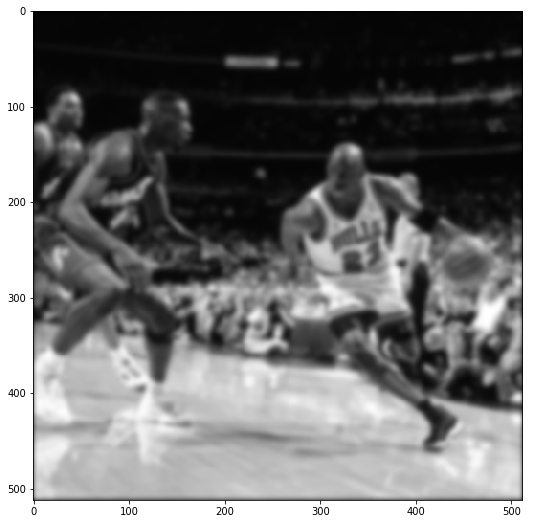

In [204]:
image2 = greyscale_blur_filter(img, gaussian_kernel(15))
plt.figure(figsize=(9,9))
plt.imshow(image2, cmap = 'gray')

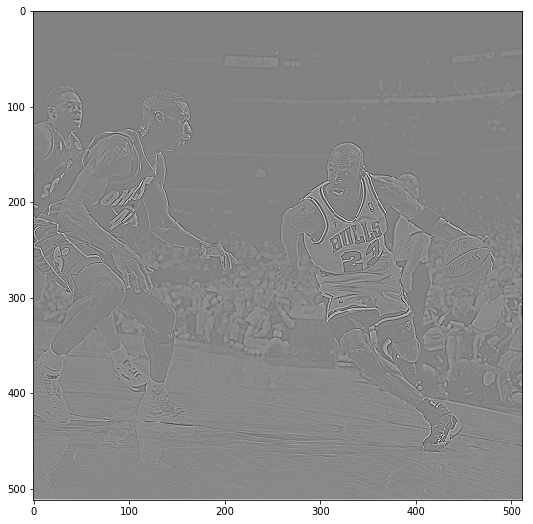

In [224]:
# High-Pass Filter
image_high = greyscale_blur_filter(img, gaussian_kernel(3))
plt.figure(figsize=(9,9))
plt.imshow((img-image_high), cmap = 'gray')

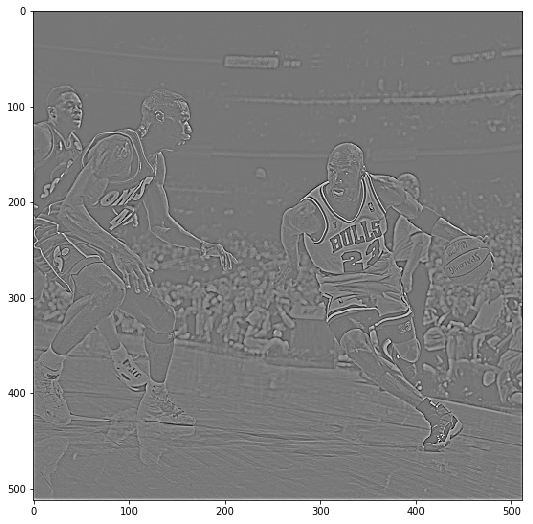

In [225]:
image_high2 = greyscale_blur_filter(img, gaussian_kernel(7))
plt.figure(figsize=(9,9))
plt.imshow((img-image_high2), cmap = 'gray')